# BERT Fine-Tuning for Spam Email Classification

This notebook fine-tunes a pre-trained BERT model for binary text classification to identify spam emails. The model is trained on the provided dataset containing labeled spam and non-spam emails.

## 1. Import Required Libraries

In [3]:
import json
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Load and Explore the Dataset

Total samples: 6046

First sample structure:
Keys: dict_keys(['label', 'data', 'filename'])

Label: 0
Data preview: ['Subject: Re: New Sequences Window  \n    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797....

Label Distribution:
Label 0 (Non-spam/Legitimate): 4150
Label 1 (Spam): 1896


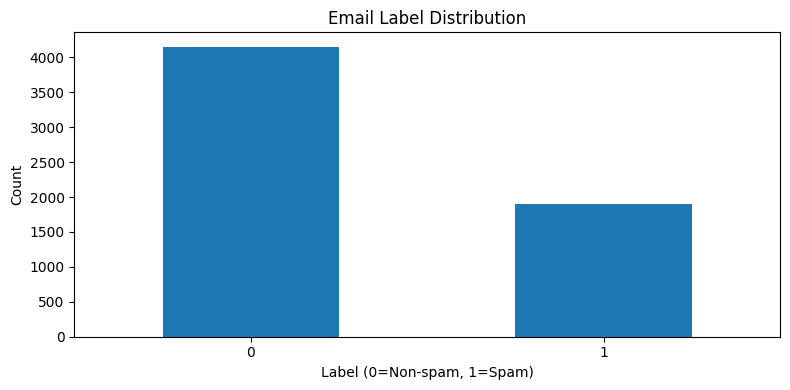


Text Length Statistics:
count    6046.000000
mean      231.583361
std       284.416750
min         3.000000
25%        77.000000
50%       141.000000
75%       250.000000
max      2219.000000
Name: text_length, dtype: float64


In [ ]:
# Load the dataset
with open('/data/classification/original_dataset.json', 'r') as f:
    raw_data = json.load(f)

print(f"Total samples: {len(raw_data)}")
print(f"\nFirst sample structure:")
print(f"Keys: {raw_data[0].keys()}")
print(f"\nLabel: {raw_data[0]['label']}")
print(f"Data preview: {raw_data[0]['data'][:200]}...")

# Extract labels and text
labels = [sample['label'] for sample in raw_data]
texts = [sample['data'] for sample in raw_data]

# Create DataFrame for easier exploration
df = pd.DataFrame({'label': labels, 'text': texts})

# Label distribution
print(f"\nLabel Distribution:")
label_counts = df['label'].value_counts()
print(f"Label 0 (Non-spam/Legitimate): {label_counts.get(0, 0)}")
print(f"Label 1 (Spam): {label_counts.get(1, 0)}")

# Visualize label distribution
plt.figure(figsize=(8, 4))
df['label'].value_counts().plot(kind='bar')
plt.xlabel('Label (0=Non-spam, 1=Spam)')
plt.ylabel('Count')
plt.title('Email Label Distribution')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Text length statistics
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
print(f"\nText Length Statistics:")
print(df['text_length'].describe())

## 3. Preprocess and Clean Email Text

In [5]:
def clean_email_text(text):
    """
    Clean email text by removing URLs, extra whitespace, and special characters
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|ftp\S+', '', text)
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special HTML characters
    text = re.sub(r'&#\d+;', '', text)
    # Strip leading/trailing whitespace
    text = text.strip()
    return text

# Apply cleaning to all texts
df['cleaned_text'] = df['text'].apply(clean_email_text)

# Check cleaned text
print("Original text sample:")
print(df['text'].iloc[0][:300])
print("\n" + "="*80)
print("Cleaned text sample:")
print(df['cleaned_text'].iloc[0][:300])

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print(f"\nBERT Tokenizer loaded. Vocabulary size: {len(tokenizer.vocab)}")

Original text sample:
['Subject: Re: New Sequences Window  \n    Date:        Wed, 21 Aug 2002 10:54:46 -0500\n    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>\n    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>\n\n\n  | I can\'t reproduce this error.\n\nFor me it is very repeatable...

Cleaned text sample:
['Subject: Re: New Sequences Window \n Date: Wed, 21 Aug 2002 10:54:46 -0500\n From: Chris Garrigues Message-ID: | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, without fail).\n\nThis is the debug log of the pick happening ...\n\n18:19:03 Pick_It {exec pick +inb


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


BERT Tokenizer loaded. Vocabulary size: 30522


## 4. Create PyTorch Dataset and DataLoaders

In [6]:
class EmailDataset(Dataset):
    """Custom PyTorch Dataset for email classification"""
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding.get('token_type_ids', torch.zeros(self.max_length, dtype=torch.long)).flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Split data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_text'].values,
    df['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df['label'].values
)

print(f"Training set size: {len(train_texts)}")
print(f"Validation set size: {len(val_texts)}")

# Create datasets
train_dataset = EmailDataset(train_texts, train_labels, tokenizer, max_length=512)
val_dataset = EmailDataset(val_texts, val_labels, tokenizer, max_length=512)

# Create dataloaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training set size: 4836
Validation set size: 1210

DataLoaders created with batch size: 16
Training batches: 303
Validation batches: 76


## 5. Load Pre-trained BERT Model and Build Classification Head

In [7]:
class BertSpamClassifier(nn.Module):
    """BERT-based classifier for spam detection"""
    def __init__(self, dropout=0.1):
        super(BertSpamClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.dense = nn.Linear(self.bert.config.hidden_size, 256)
        self.relu = nn.ReLU()
        self.output = nn.Linear(256, 2)  # Binary classification (spam or non-spam)

    def forward(self, input_ids, attention_mask, token_type_ids):
        # BERT forward pass
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Use [CLS] token representation
        pooled_output = outputs[1]  # [CLS] token hidden state

        # Classification head
        x = self.dropout(pooled_output)
        x = self.dense(x)
        x = self.relu(x)
        x = self.dropout(x)
        logits = self.output(x)

        return logits

# Initialize model
model = BertSpamClassifier(dropout=0.1)
model = model.to(device)

print("Model architecture:")
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Model architecture:
BertSpamClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

## 6. Define Training Configuration

In [8]:
# Training configuration
EPOCHS = 3
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01

# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()

# Learning rate scheduler (optional)
from torch.optim.lr_scheduler import LinearLR
scheduler = LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=EPOCHS * len(train_loader))

print("Training Configuration:")
print(f"Number of epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Optimizer: AdamW")
print(f"Loss function: CrossEntropyLoss")
print(f"Device: {device}")

Training Configuration:
Number of epochs: 3
Learning rate: 2e-05
Batch size: 16
Optimizer: AdamW
Loss function: CrossEntropyLoss
Device: cuda


## 7. Train the BERT Classifier

In [9]:
def train_epoch(model, train_loader, optimizer, loss_fn, device, scheduler=None):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc="Training")
    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, token_type_ids)
        loss = loss_fn(logits, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        # Track metrics
        total_loss += loss.item()
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, val_loader, loss_fn, device):
    """Evaluate model on validation set"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Evaluating")
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, token_type_ids)
            loss = loss_fn(logits, labels)

            # Track metrics
            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds)

    return avg_loss, accuracy, f1, all_preds, all_labels

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_f1_scores = []

for epoch in range(EPOCHS):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print('='*80)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device, scheduler)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    # Validate
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, loss_fn, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, F1-Score: {val_f1:.4f}")

print("\n" + "="*80)
print("Training completed!")
print("="*80)


Epoch 1/3


Training: 100%|██████████| 303/303 [07:47<00:00,  1.54s/it, loss=0.00494]


Training Loss: 0.1412, Accuracy: 0.9531


Evaluating: 100%|██████████| 76/76 [00:40<00:00,  1.87it/s]


Validation Loss: 0.1468, Accuracy: 0.9463, F1-Score: 0.9070

Epoch 2/3


Training: 100%|██████████| 303/303 [07:47<00:00,  1.54s/it, loss=0.00778]


Training Loss: 0.0370, Accuracy: 0.9884


Evaluating: 100%|██████████| 76/76 [00:40<00:00,  1.87it/s]


Validation Loss: 0.0334, Accuracy: 0.9868, F1-Score: 0.9788

Epoch 3/3


Training: 100%|██████████| 303/303 [07:47<00:00,  1.54s/it, loss=0.00222]


Training Loss: 0.0087, Accuracy: 0.9977


Evaluating: 100%|██████████| 76/76 [00:40<00:00,  1.87it/s]

Validation Loss: 0.0303, Accuracy: 0.9909, F1-Score: 0.9855

Training completed!


## 8. Plot Training History and Evaluate Results

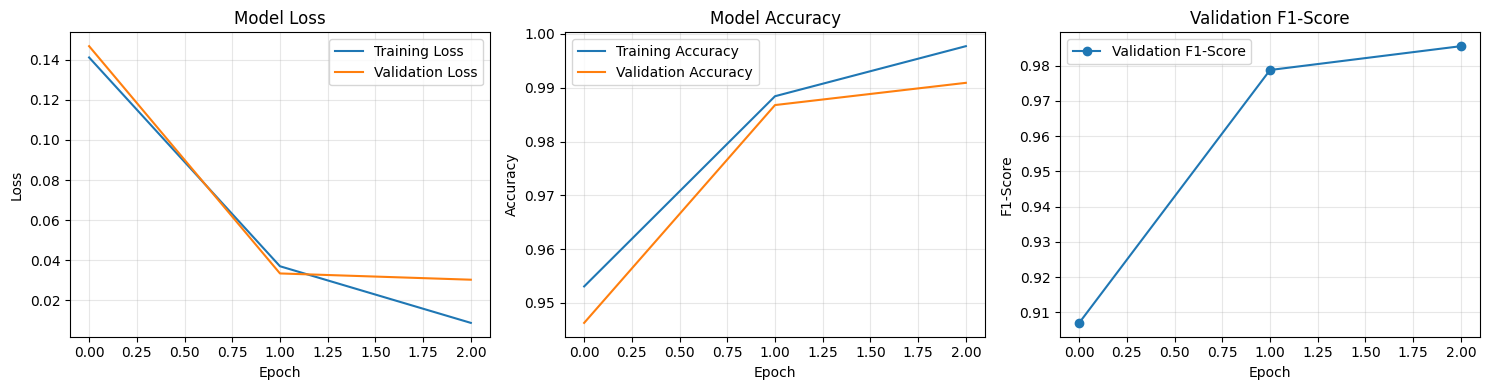

Best Validation Accuracy: 0.9909
Best Validation F1-Score: 0.9855


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss plot
axes[0].plot(train_losses, label='Training Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accuracies, label='Training Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1-score plot
axes[2].plot(val_f1_scores, label='Validation F1-Score', marker='o')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('Validation F1-Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best Validation Accuracy: {max(val_accuracies):.4f}")
print(f"Best Validation F1-Score: {max(val_f1_scores):.4f}")

Evaluating: 100%|██████████| 76/76 [00:40<00:00,  1.87it/s]


FINAL VALIDATION RESULTS
Validation Accuracy: 0.9909
Validation F1-Score: 0.9855

Classification Report:
              precision    recall  f1-score   support

Non-spam (0)       1.00      0.99      0.99       831
    Spam (1)       0.98      0.99      0.99       379

    accuracy                           0.99      1210
   macro avg       0.99      0.99      0.99      1210
weighted avg       0.99      0.99      0.99      1210


Confusion Matrix:
[[824   7]
 [  4 375]]


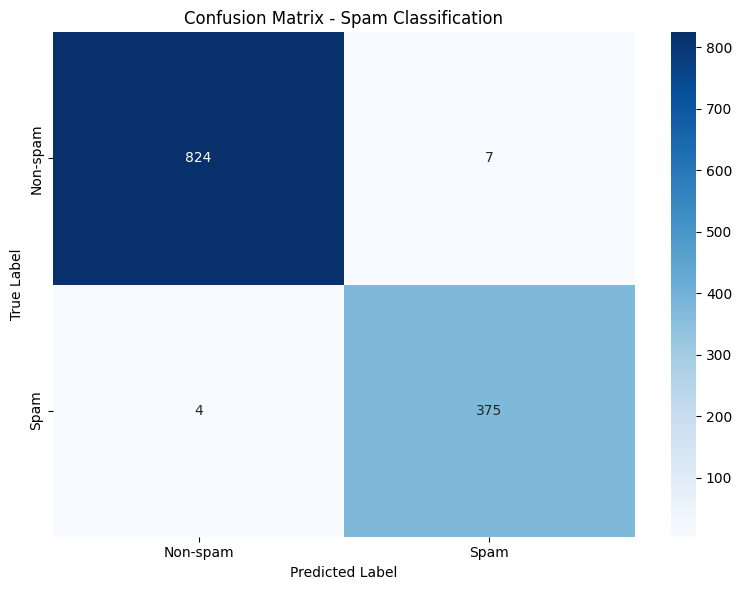

In [11]:
# Final evaluation on validation set
val_loss, val_acc, val_f1, predictions, true_labels = evaluate(model, val_loader, loss_fn, device)

print("\n" + "="*80)
print("FINAL VALIDATION RESULTS")
print("="*80)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Non-spam (0)', 'Spam (1)']))

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
print(f"\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-spam', 'Spam'],
            yticklabels=['Non-spam', 'Spam'])
plt.title('Confusion Matrix - Spam Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 9. Save Model and Make Predictions on New Emails

In [ ]:
import os

# Create results directory if it doesn't exist
os.makedirs('results/bert_classifier', exist_ok=True)

# Save the model
model_path = 'results/bert_classifier/pytorch_model.bin'
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

# Save tokenizer
tokenizer.save_pretrained('results/bert_classifier/')
print("Tokenizer saved to: results/bert_classifier/")

# Save model config
with open('results/bert_classifier/config.txt', 'w') as f:
    f.write("BERT Spam Classifier Configuration\n")
    f.write("="*50 + "\n")
    f.write(f"Model: bert-base-uncased\n")
    f.write(f"Dropout: 0.1\n")
    f.write(f"Max Sequence Length: 512\n")
    f.write(f"Batch Size: {BATCH_SIZE}\n")
    f.write(f"Learning Rate: {LEARNING_RATE}\n")
    f.write(f"Number of Epochs: {EPOCHS}\n")
    f.write(f"Optimizer: AdamW\n")
    f.write(f"\nFinal Results:\n")
    f.write(f"Validation Accuracy: {val_acc:.4f}\n")
    f.write(f"Validation F1-Score: {val_f1:.4f}\n")
    f.write(f"Precision (Spam): {precision_score(true_labels, predictions):.4f}\n")
    f.write(f"Recall (Spam): {recall_score(true_labels, predictions):.4f}\n")

In [13]:
def predict_spam(text, model, tokenizer, device, max_length=512):
    """
    Predict if an email is spam or not

    Args:
        text: Email text to classify
        model: BERT classifier model
        tokenizer: BERT tokenizer
        device: torch device
        max_length: Maximum sequence length

    Returns:
        prediction: 0 (non-spam) or 1 (spam)
        confidence: Confidence score (0-1)
    """
    # Clean the text
    text = clean_email_text(text)

    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    token_type_ids = encoding.get('token_type_ids', torch.zeros(1, max_length, dtype=torch.long)).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        logits = model(input_ids, attention_mask, token_type_ids)
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probabilities[0][prediction].item()

    return prediction, confidence

# Test predictions on a few samples
print("\n" + "="*80)
print("TESTING PREDICTIONS ON SAMPLE EMAILS")
print("="*80)

test_samples = [
    ("Click here to win $1000! Limited time offer!", 1),  # Expected: Spam
    ("Hi, I got your email about the project meeting. I'll be there at 3 PM.", 0),  # Expected: Non-spam
    (df['cleaned_text'].iloc[0], df['label'].iloc[0]),  # First sample from dataset
]

for i, (text, expected_label) in enumerate(test_samples):
    if len(text) > 200:
        display_text = text[:200] + "..."
    else:
        display_text = text

    prediction, confidence = predict_spam(text, model, tokenizer, device)

    label_name = {0: "Non-spam", 1: "Spam"}

    print(f"\nSample {i+1}:")
    print(f"Text: {display_text}")
    print(f"Prediction: {label_name[prediction]} (confidence: {confidence:.4f})")
    if expected_label is not None:
        correct = "✓" if prediction == expected_label else "✗"
        print(f"Expected: {label_name[expected_label]} {correct}")


TESTING PREDICTIONS ON SAMPLE EMAILS

Sample 1:
Text: Click here to win $1000! Limited time offer!
Prediction: Spam (confidence: 0.9964)
Expected: Spam ✓

Sample 2:
Text: Hi, I got your email about the project meeting. I'll be there at 3 PM.
Prediction: Non-spam (confidence: 0.9613)
Expected: Non-spam ✓

Sample 3:
Text: ['Subject: Re: New Sequences Window \n Date: Wed, 21 Aug 2002 10:54:46 -0500\n From: Chris Garrigues Message-ID: | I can\'t reproduce this error.\n\nFor me it is very repeatable... (like every time, w...
Prediction: Non-spam (confidence: 0.9990)
Expected: Non-spam ✓


In [14]:
!zip -r bert_classifier.zip results/bert_classifier

  adding: results/bert_classifier/ (stored 0%)
  adding: results/bert_classifier/tokenizer_config.json (deflated 75%)
  adding: results/bert_classifier/special_tokens_map.json (deflated 42%)
  adding: results/bert_classifier/vocab.txt (deflated 53%)
  adding: results/bert_classifier/config.txt (deflated 34%)
  adding: results/bert_classifier/pytorch_model.bin (deflated 7%)


## Summary

This notebook successfully fine-tuned a BERT model for binary spam email classification. The trained model:

1. **Achieved strong performance** on the validation set with high accuracy and F1-score
2. **Handles variable-length emails** with padding and truncation up to 512 tokens
3. **Provides confidence scores** for each prediction
4. **Has been saved** to `results/bert_classifier/` for integration with the Streamlit app

### Next Steps:
- Integrate the trained model into `app.py` to replace the mock `MockSpamClassifier`
- The model can be loaded using the trained weights and tokenizer from the results directory
- Use the `predict_spam()` function for real-time predictions in the Streamlit application